In [89]:
#@title Imports and Notebook Utilities

# System imports

import sys
import os
import io
import re
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()


In [3]:
print(os.getcwd())
os.chdir('caproject')
print(os.getcwd())
!ls

/u/sradev/deep-learning-project
/u/sradev/deep-learning-project/caproject
experiments.py	     images    out.txt	       train.py
figures		     main.py   __pycache__     train_steps_damage_0.mp4
figures.py	     Makefile  test.py	       utils.py
image_processing.py  model.py  test_video.mp4


In [15]:
# Module imports

import importlib
import caproject.model, experiments, image_processing, utils, figures, train

def force_import(module: str):
    importlib.reload(sys.modules[module])
    

In [127]:
force_import('model')
force_import('utils')
force_import('experiments')
force_import('train')
import model, train, experiments


...........................IN model.py...........................

...........................IN utils.py...........................

...........................IN train.py...........................


In [175]:
CHANNEL_N = 16
HIDDEN_SIZE = 128
TARGET_SIZE = 48
EXPERIMENT_TYPE = "persistent"

IMAGE_TARGET_MAP = {'bob-ross-painting': 135, 'starry-night': 150, 'sleigh': 48, 
                    'mozart1': 48, 'mozart': 48}

# Define some common-use image name-target pairs
br, sn, s, m1, m = 'bob-ross-painting', 'starry-night', 'sleigh', 'mozart1', 'mozart'


def get_hidden_size_name(hidden_size):
    hidden_size_name = hidden_size
    if type(hidden_size) == list:
        hidden_size_name = '-'.join(str(e) for e in hidden_size)
    elif type(hidden_size) != int:
        sys.exit("get_hidden_size_name: Hidden size must be either int or list")
    return hidden_size_name

def get_models(image_name, target_size, channel_n=None, hidden_size=None, experiment_type=EXPERIMENT_TYPE):
    """Given an image name and its target size, locate the directory and return a list of all models.
       If channel_n or hidden_size specified, return only those models.
    """
    
    channels = []
    hidden_sizes = []
    path = f'figures/{image_name}-{target_size}/{experiment_type}/'
    for model in os.listdir(path):
        model_name_lst = re.split("[-|_]", model)
        assert model_name_lst[0] == 'channel' and model_name_lst[2] == 'hidden'
        channels.append(int(model_name_lst[1]))
        if len(model_name_lst) == 4: hidden_sizes.append(int(model_name_lst[3]))
        else: hidden_sizes.append([int(n) for n in model_name_lst[3:]])
        
    return channels, hidden_sizes
        
    # # If both are provided, return that specific model 
    # if channel_n and hidden_size:
    #     assert channel_n in channels and hidden_size in hidden_sizes
    #     hidden_size_name = get_hidden_size_name(hidden_size)
    #     path += f'channel-{channel_n}_hidden-{hidden_size_name}/'
        

def get_dir(image_name, channel_n=None, hidden_size=None, target_size=None, 
            experiment_type=EXPERIMENT_TYPE, plot_loss=True):
    """Given an image name, iterates""" 

    if not target_size:
        target_size = IMAGE_TARGET_MAP[image_name]
    path = f'figures/{image_name}-{target_size}/{experiment_type}/'    

    def get_dir_helper(path, channel_n, hidden_size):
        hidden_size_name = get_hidden_size_name(hidden_size)
        path += f'channel-{channel_n}_hidden-{hidden_size_name}/'
        loss_log = np.load(path+'loss_log.npy')
        if plot_loss:
            return train.plot_loss(loss_log, channel_n=channel_n, hidden_size=hidden_size, image_name=image_name,\
                    target_size=target_size, save=False, path=mozart_dir)
    
    loss_log = []
    if channel_n and hidden_size:
        get_dir_helper(path, channel_n, hidden_size)
        # hidden_size_name = get_hidden_size_name(hidden_size)
        # path += f'channel-{channel_n}_hidden-{hidden_size_name}/'
        # loss_log = np.load(path+'loss_log.npy')
        # if plot_loss:
        #     train.plot_loss(loss_log, channel_n=CHANNEL_N, hidden_size=HIDDEN_SIZE, image_name=image_name,\
        #                     target_size=TARGET_SIZE, save=False, path=mozart_dir)
            
    # Get all channels and hidden sizes for requested image name and target size
    channels, hidden_sizes = get_models(image_name, target_size, channel_n, hidden_size)
    models = os.listdir(path)
    model_indices = []        
    # print(channels)
    
    # Handle the different cases
    if channel_n and not hidden_size:
        print(channels)
        model_indices = list(np.where(np.array(channels) == channel_n)[0])
        print(list(np.where(np.array(channels) == channel_n)[0]))
    elif hidden_size and not channel_n:
        
        model_indices = list(np.where(np.array(hidden_sizes) == hidden_size)[0])
        
    print(channels)
    print(model_indices)
    print(hidden_sizes)
    
    for model_index in model_indices:
        # print(model_index)
        print(channels[model_index])
        # channel_n: channels[model_index]
        # hidden_size: hidden_sizes[model_index]
        pl = get_dir_helper(path, channels[model_index], hidden_sizes[model_index])
        # pl.plot(

    return path, loss_log
        
    

[24, 24, 28, 40, 28, 60, 16, 28, 20, 20, 24, 28]
[5, 6]
[160, 192, [64, 128], 256, [64, 128, 32], 128, 128, 256, 256, 192, 256, [128, 64]]
60
16
figures/bob-ross-painting-135/persistent/ []


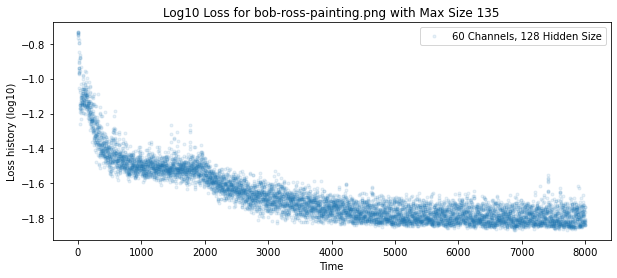

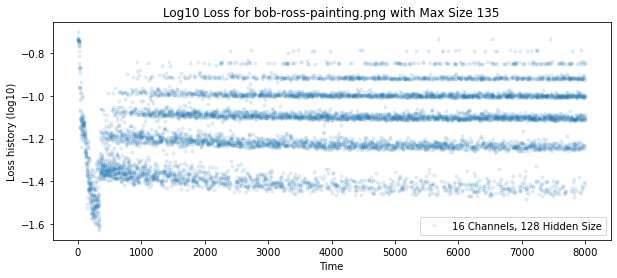

In [176]:
mozart_dir, loss_log = get_dir(br, None, 128)
print(mozart_dir, loss_log)

figures/bob-ross-painting-135/persistent/channel-16_hidden-128/ [0.18419454 0.18428871 0.18383944 ... 0.14217858 0.07782964 0.12021103]


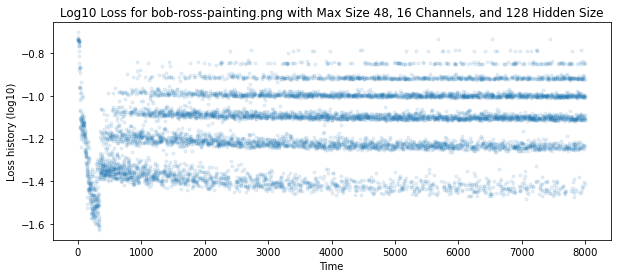

In [85]:
mozart_dir, loss_log = get_dir(br, channel_n=CHANNEL_N, hidden_size=HIDDEN_SIZE)
print(mozart_dir, loss_log)

In [ ]:
# image_name = 'bob-ross-painting'
image_name = 'starry-night'
image_name = 'sleigh'

DIR = f'figures/{image_name}-{TARGET_SIZE}/{EXPERIMENT_TYPE}/channel-{CHANNEL_N}_hidden-{hidden_size_name}/'
DIR2 = f'figures/{image_name}-{TARGET_SIZE}/{EXPERIMENT_TYPE}/'
!ls $DIR
print(DIR)
os.getcwd()